# Exercice 1

##### Réponse / idées : 

In [1]:
import json
import pandas as pd

import urllib.request
import urllib.parse

import sklearn
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import label_binarize, LabelBinarizer

import matplotlib.pyplot as plt
import itertools
import numpy as np
import seaborn as sns

### Récupération des données d'entrainement et de test

In [2]:
# Reading training_set file 
with open('training_set.json', encoding="utf8") as json_file:
    training_data = json.load(json_file)
    
# Reading testing_set file 
with open('testing_set.json', encoding="utf8") as json_file:
    testing_data = json.load(json_file)

###### On charge aussi les données sous forme de dataframe pendant pour faciliter leur manipulation

In [3]:
# Loading training data in pandas Dataframe
df_train = pd.read_json("training_set.json")

# Loading testing data in pandas Dataframe
df_test = pd.read_json('testing_set.json')

## Analyses des données

### Analyse des données d'entrainement

In [4]:
# Print df_train shape (rows and columns)
print(f"Training data shape: {df_train.shape}")

Training data shape: (6035, 2)


In [5]:
# Print df_train info
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6035 entries, 0 to 6034
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   intent    6035 non-null   object
 1   sentence  6035 non-null   object
dtypes: object(2)
memory usage: 94.4+ KB


###### Les données d'entrainement comportent 6035 utterances et sont présentées en deux colonnes, une pour la classe (intent) et une pour l'utterance (sentence). Il ne manque aucune valeur.

In [6]:
# Print statistical description
df_train.describe()

,intent,sentence
count,6035,6035
unique,8,6035
top,irrelevant,"je suis à la recherche dune locations, pr 9 pe..."
freq,3852,1


###### Ce tableau montre qu'il y a 8 classes et montre que la classe la plus représentée est la classe 'irrelevant' avec 3852 occurances, soit plus de la moitié des utterances. On peut dire que les données sont déséquilibrées.

In [7]:
# Counting the number of data (train) for each intent
train_data = {'find-train': 0, 'irrelevant': 0, 'find-flight': 0, 'find-restaurant': 0,
           'purchase': 0, 'find-around-me' : 0, 'provide-showtimes' : 0, 'find-hotel' : 0}
for i in range(len(training_data)):
    for intent, count in train_data.items():
        if training_data[i]['intent'] == intent :
            count = count + 1
            train_data[intent] = count

# Counting each intent iteration
train_data

{'find-train': 143,
 'irrelevant': 3852,
 'find-flight': 142,
 'find-restaurant': 469,
 'purchase': 613,
 'find-around-me': 383,
 'provide-showtimes': 117,
 'find-hotel': 316}

###### Ici nous pouvons voir le nombre d'utterance par classe, et on observe très clairement que la répartition des données dans les différentes est très déséquilibrées. Les classes 'find-train', 'find-flight' et 'provide-showtimes' sont très peu représentées. La classe 'irrelevant' fait presque 30 fois la taille de ces classes, et 10 fois la taille des classes 'find-around-me' et 'find-hotel'.

### Analyses des données de test

###### Dans cette partie, on va mener les mêmes analyses que menées dans la partie précédente, mais sur les données de test.

In [8]:
# Print df_test shape (rows and columns)
print(f"Testing data shape: {df_test.shape}")

Testing data shape: (1065, 2)


In [9]:
# Print df_test info
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1065 entries, 0 to 1064
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   intent    1065 non-null   object
 1   sentence  1065 non-null   object
dtypes: object(2)
memory usage: 16.8+ KB


###### Les données de test comportent 1065 utterances. Il ne manque aucune valeur.

In [10]:
# Print statistical description
df_test.describe()

,intent,sentence
count,1065,1065
unique,8,1064
top,irrelevant,Est ce que tu connais des sites internet sur l...
freq,677,2


###### Encore une fois, la classe 'irrelevant' est la plus représentée, avec 677 utterances, donc plus de la moitié des données de test. Les données sont encore une fois déséquilibrées.

In [11]:
# Counting the number of data (test) for each intent
test_data = {'find-train': 0, 'irrelevant': 0, 'find-flight': 0, 'find-restaurant': 0,
           'purchase': 0, 'find-around-me' : 0, 'provide-showtimes' : 0, 'find-hotel' : 0}
for i in range(len(testing_data)):
    for intent, count in test_data.items():
        if testing_data[i]['intent'] == intent :
            count = count + 1
            test_data[intent] = count

# Counting each intent iteration
test_data

{'find-train': 21,
 'irrelevant': 677,
 'find-flight': 24,
 'find-restaurant': 93,
 'purchase': 114,
 'find-around-me': 67,
 'provide-showtimes': 14,
 'find-hotel': 55}

###### Les classes 'find-train', 'find-flight' et 'provide-show-times' sont encore une fois très peu représentées. La répartition dans les différentes classes est très déséquilibrée.

### Analyse du modèle

In [12]:
# Splitting data into features (sentence) and target (intent)
x_train = df_train['sentence'] 
y_train = df_train['intent'] 

x_test = df_test['sentence']
y_test = df_test['intent']

In [13]:
# Fetching predictions from urllib
def get_prediction(features):
    url = "http://localhost:8080/api/intent?sentence="
    
    labels = []
    for sentence in features:
        sentence = urllib.parse.quote(sentence)
        get_pred = urllib.request.urlopen(url+sentence)
        prediction = json.load(get_pred)

        label = max(prediction, key=prediction.get)
        labels.append(label)
    
    df_pred = pd.DataFrame({'prediction':labels})
    
    return df_pred

In [15]:
# Computing Precision, Recall, F1 score using scikit-learn
report = classification_report(y_test, get_prediction(x_test))
print(report)



                   precision    recall  f1-score   support

   find-around-me       0.88      0.43      0.58        67
      find-flight       0.88      0.29      0.44        24
       find-hotel       0.78      0.38      0.51        55
  find-restaurant       0.98      0.56      0.71        93
       find-train       0.93      0.67      0.78        21
       irrelevant       0.79      0.98      0.87       677
provide-showtimes       0.80      0.29      0.42        14
         purchase       0.79      0.59      0.67       114

         accuracy                           0.80      1065
        macro avg       0.85      0.52      0.62      1065
     weighted avg       0.82      0.80      0.78      1065



###### On constate que mis à part la classe 'irrelevant', les scores pour les métriques recall et f1 sont mauvais.
###### Un score bas pour le recall signifie que la proportion d'utterance que le modèle a su classer dans une classe est faible par rapport au nombre total d'utterance dans cette classe.

In [16]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    
    labels = ['find-train', 'irrelevant', 'find-flight', 'find-restaurant', 'purchase', 'find-around-me', 'provide-showtimes', 'find-hotel']
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45, fontsize=15)
    plt.yticks(tick_marks, labels, fontsize=15)
    
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    cm = np.around(cm, decimals=2)

    thresh = 0.70
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=15)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=20)
    plt.xlabel('Predicted label', fontsize=20)

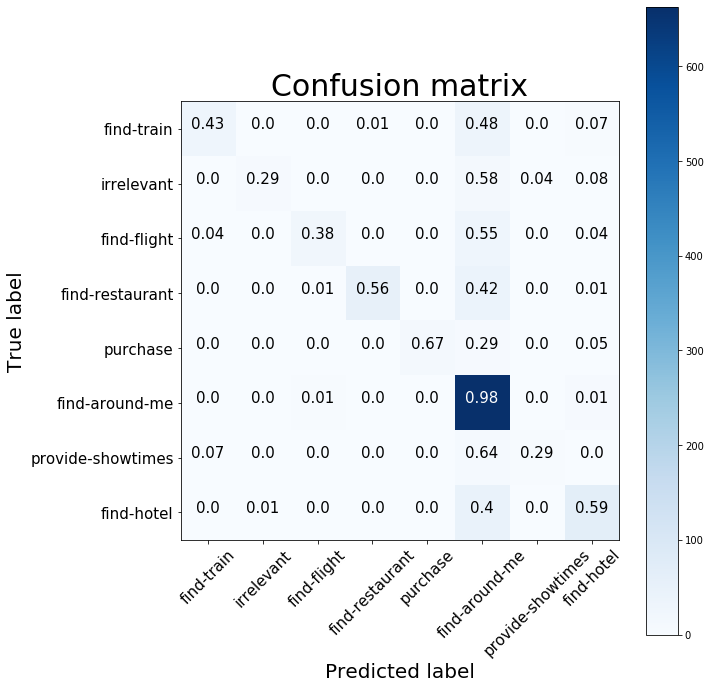

In [17]:
# Plot confusion matrix
df_pred = get_prediction(x_test)
conf_mat = confusion_matrix(y_test, df_pred)

plt.figure(figsize=(10,10))
plot_confusion_matrix(conf_mat)
plt.show()

###### Sur cette matrice de confusion, on voit que le modèle prédit assez mal les classes.

In [18]:
# Fetching real class score
def get_scores(features):
    url = "http://localhost:8080/api/intent?sentence="
    
    labels = ['find-train', 'irrelevant', 'find-flight', 'find-restaurant', 'purchase', 'find-around-me', 'provide-showtimes', 'find-hotel']
    
    scores = []
    for i in range(len(features)):
        
        sentence = urllib.parse.quote(features[i])
        get_pred = urllib.request.urlopen(url+sentence)
        prediction = json.load(get_pred)
        
        score = []
        for label in labels:
            score_label = prediction[label]
            score.append(score_label)
            
        # label_score = prediction[labels[i]]
        scores.append(score)
    
    scores = np.array(scores)
    
    
    return scores

y_test_score = get_scores(x_test)
print(y_test_score)

[[1.90632511e-02 3.88084888e-01 2.71791965e-02 ... 7.45929331e-02
  1.09721571e-02 2.79567167e-02]
 [3.32277641e-02 5.41999936e-01 2.76485924e-02 ... 6.27820492e-02
  3.48897204e-02 1.81026146e-01]
 [1.70242675e-02 7.04971135e-01 2.02584993e-02 ... 3.43001336e-02
  2.56650075e-02 3.73521261e-02]
 ...
 [3.95856751e-03 8.96818399e-01 3.24731739e-03 ... 4.28173356e-02
  4.51520231e-04 1.77550483e-02]
 [1.45552484e-02 1.04366422e-01 3.02942675e-02 ... 3.51525843e-01
  1.07253343e-02 5.60341254e-02]
 [1.06861512e-03 9.59956288e-01 7.67351070e-04 ... 3.50412307e-03
  1.22734607e-04 2.46229451e-02]]


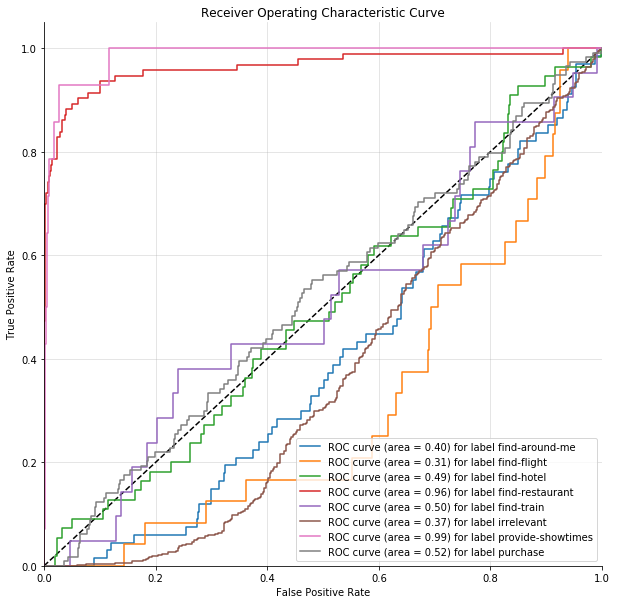

In [20]:
def plot_multiclass_roc_curve(scores, labels):
    # il faut binariser les labels
    lb = LabelBinarizer()
    encoded_labels = lb.fit(labels)
    classes = encoded_labels.classes_ # on récupère les classes dans l'ordre de sortie du modèle
    encoded_labels = encoded_labels.transform(labels)

    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(encoded_labels[:,i], scores[:, i]) # il faut le score de toutes les catégories
        roc_auc[i] = auc(fpr[i], tpr[i]) 

    fig, ax = plt.subplots(figsize=(10,10))
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title('Receiver Operating Characteristic Curve')
    for i in range(len(classes)):
        ax.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f) for label %s' % (roc_auc[i], classes[i]))
    ax.legend(loc="best")
    ax.grid(alpha=.4)
    sns.despine()
    plt.show()
    
plot_multiclass_roc_curve(y_test_score, y_test)

In [26]:
lb = LabelBinarizer()
encoded_labels = lb.fit(y_test)
encoded_labels = encoded_labels.transform(y_test)

classes = encoded_labels.classes_ # on récupère les classes dans l'ordre de sortie du modèle
print(classes)

roc_score = roc_auc_score(encoded_labels, y_test_score, multi_class='ovo', average='macro')
print(roc_score)

# très étrange, quand je binairise les labels c'est 93% et quand je binairise pas c'est 57%

AttributeError: 'numpy.ndarray' object has no attribute 'classes_'

# Exercice 2

##### Réponse / idées : 

In [ ]:
# la valeur de threshold est peut-être trop faible pour le modèle précédent car tout fini en 'irrelevant'
# si le score en sortie de softmax (généralement la dernière couche d'un problème de classification) d'aucune des classes n'est supérieure à ce threshold, alors la classe prédite est "irrelevant"

In [42]:
def get_true_label_score(features, labels):
    url = "http://localhost:8080/api/intent?sentence="
    
    scores = []
    labels_pred = []
    for i in range(len(features)):
        sentence = urllib.parse.quote(features[i])
        get_pred = urllib.request.urlopen(url+sentence)
        prediction = json.load(get_pred)
        
        label_score = prediction[labels[i]]
        scores.append(label_score)
        labels_pred.append(labels[i])
    
    label_scores = pd.DataFrame({'Label':labels_pred, 'Scores':scores})
    
    return label_scores

y_test_score = get_true_label_score(x_test, y_test)
print(y_test_score)


    

                Label    Scores
0          irrelevant  0.388085
1          irrelevant  0.542000
2          irrelevant  0.704971
3            purchase  0.286700
4     find-restaurant  0.581406
...               ...       ...
1060       irrelevant  0.980859
1061       find-train  0.086588
1062       irrelevant  0.896818
1063   find-around-me  0.351526
1064       irrelevant  0.959956

[1065 rows x 2 columns]


In [43]:
# On calcule la moyenne et l'écart type
def mean_std_score_label(scores):
    labels = ['find-train', 'irrelevant', 'find-flight', 'find-restaurant', 'purchase', 'find-around-me', 'provide-showtimes', 'find-hotel']
    
    mean = []
    std = []
    for label in labels:
        mean_label = scores.loc[scores['Label'].isin([label]), 'Scores'].mean()
        std_label = scores.loc[scores['Label'].isin([label]), 'Scores'].std()
        
        mean.append(mean_label)
        std.append(std_label)
    
    
    mean_scores = pd.DataFrame({'Label':labels, 'Mean':mean, 'Standard deviation':std})
    
    return mean_scores

mean_scores = mean_std_score_label(y_test_score)
print(mean_scores)


               Label      Mean  Standard deviation
0         find-train  0.449604            0.293161
1         irrelevant  0.726593            0.176583
2        find-flight  0.245033            0.208919
3    find-restaurant  0.451119            0.253929
4           purchase  0.457684            0.241340
5     find-around-me  0.331112            0.237720
6  provide-showtimes  0.275741            0.206900
7         find-hotel  0.333029            0.262380


In [45]:
def get_prediction_score(features):
    url = "http://localhost:8080/api/intent?sentence="
    
    labels = []
    scores = []
    for sentence in features:
        sentence = urllib.parse.quote(sentence)
        get_pred = urllib.request.urlopen(url+sentence)
        prediction = json.load(get_pred)

        label = max(prediction, key=prediction.get)
        labels.append(label)
        label_score = prediction[label]
        scores.append(label_score)
    
    df_pred = pd.DataFrame({'Label':labels, 'Scores':scores})
    
    return df_pred

In [49]:
y_test_score = get_true_label_score(x_test, y_test)
print("True label\n")
print(y_test_score)

print("\n\nPred label")
y_test_pred_score = get_prediction_score(x_test)
print(y_test_pred_score)

True label

                Label    Scores
0          irrelevant  0.388085
1          irrelevant  0.542000
2          irrelevant  0.704971
3            purchase  0.286700
4     find-restaurant  0.581406
...               ...       ...
1060       irrelevant  0.980859
1061       find-train  0.086588
1062       irrelevant  0.896818
1063   find-around-me  0.351526
1064       irrelevant  0.959956

[1065 rows x 2 columns]


Pred label
                Label    Scores
0            purchase  0.398776
1          irrelevant  0.542000
2          irrelevant  0.704971
3          irrelevant  0.422897
4     find-restaurant  0.581406
...               ...       ...
1060       irrelevant  0.980859
1061       irrelevant  0.548353
1062       irrelevant  0.896818
1063   find-around-me  0.351526
1064       irrelevant  0.959956

[1065 rows x 2 columns]


In [48]:
mean_scores_true_label = mean_std_score_label(y_test_score)
print("True label\n")
print(mean_scores_true_label)

print("\n\nPred label")
mean_scores_pred = mean_std_score_label(y_test_pred_score)
print(mean_scores_pred)

True label

               Label      Mean  Standard deviation
0         find-train  0.449604            0.293161
1         irrelevant  0.726593            0.176583
2        find-flight  0.245033            0.208919
3    find-restaurant  0.451119            0.253929
4           purchase  0.457684            0.241340
5     find-around-me  0.331112            0.237720
6  provide-showtimes  0.275741            0.206900
7         find-hotel  0.333029            0.262380


Pred label
               Label      Mean  Standard deviation
0         find-train  0.618993            0.165794
1         irrelevant  0.696638            0.180273
2        find-flight  0.458716            0.207123
3    find-restaurant  0.627901            0.171638
4           purchase  0.579623            0.182335
5     find-around-me  0.534724            0.170683
6  provide-showtimes  0.533762            0.147931
7         find-hotel  0.624692            0.182335


## Exercice 3

##### Réponse / idées : 

## Exercice 4

##### Réponse / idées : 

## Exercice 5

##### Réponse / idées : 